In [1]:
import xarray as xr
import intake,yaml,os
import intake_esm
import matplotlib
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from dask.diagnostics import ProgressBar
import numpy as np
import datetime

sim_year = 2024

In [3]:
# 2021
if sim_year == 2021:
    col_url = "/home/tmerlis/hackathon/catbuild/xshield_cat.json"
    experiment_id_name = '20191020.00Z.C3072.L79x2_pire_PLUS_4K'
    dict_key = 'GLOBALFV3.20191020.00Z.C3072.L79x2_pire_PLUS_4K.processed_new'
    var_names = ['iw_coarse_C3072_1440x720', 'clt_coarse_C3072_1440x720', 'ULWRFtoa_coarse_C3072_1440x720']

# 2024
if sim_year == 2024:
    col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"
    experiment_id_name = '20191020.00Z.C3072.xs24v2'
    dict_key = '20191020.00Z.C3072.xs24v2.GLOBALFV3'
    var_names = ['iw_coarse_C3072_1440x720', 'clt_coarse_C3072_1440x720', 'rlut_coarse_C3072_1440x720']
    
col = intake.open_esm_datastore(col_url)

In [4]:
ds_list = []
for var_id_name in var_names:
    print(var_id_name)
    if sim_year == 2021:
        cat = col.search(variable_id = var_id_name, experiment_id = experiment_id_name)
    else:
        cat = col.search(variable_id = var_id_name)
    dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
    ds = dset_dict[dict_key]
    if (var_id_name == 'rlut_coarse_C3072_1440x720'):
        ds = ds.assign(time=lambda x: x.time  + datetime.timedelta(hours=1.5))
    ds_list.append(ds)

iw_coarse_C3072_1440x720

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


clt_coarse_C3072_1440x720

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


rlut_coarse_C3072_1440x720

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


In [5]:
ds_all = xr.merge(ds_list)
ds_all

<xarray.Dataset> Size: 44GB
Dimensions:              (time: 3560, grid_yt_coarse: 720, bnds: 2,
                          grid_xt_coarse: 1440)
Coordinates:
  * time                 (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-0...
  * grid_yt_coarse       (grid_yt_coarse) float32 3kB -89.88 -89.62 ... 89.88
    grid_yt_coarse_bnds  (grid_yt_coarse, bnds) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * grid_xt_coarse       (grid_xt_coarse) float32 6kB 0.125 0.375 ... 359.9
    grid_xt_coarse_bnds  (grid_xt_coarse, bnds) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    iw_coarse            (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    clt_coarse           (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    time_bnds            (time, bnds) object 57kB dask.array<chunksize=(5, 2), meta=np.ndarray>
    rlut_coarse          (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    *empty*
Attributes:
    title:                           202407.20191020.00Z.C3072.xs24v2
    grid_type:                       regular
    grid_tile:                       N/A
    code_release_version:            2024.02
    git_hash:                        b86d27037f755a82c586e55073dd575245c144b1
    intake_esm_vars:                 ['iw_coarse_C3072_1440x720']
    intake_esm_attrs:experiment_id:  20191020.00Z.C3072.xs24v2
    intake_esm_attrs:member_id:      GLOBALFV3
    intake_esm_attrs:variable_id:    iw_coarse_C3072_1440x720
    intake_esm_attrs:platform:       cimes
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          20191020.00Z.C3072.xs24v2.GLOBALFV3

In [6]:
ds_all = ds_all.rename({'iw_coarse':'clivi', 'clt_coarse':'clt'})
if sim_year == 2021:
    ds_all = ds_all.rename({'ULWRFtoa_coarse':'rlut'})
if sim_year == 2024:
    ds_all = ds_all.rename({'rlut_coarse':'rlut'})

In [7]:
with ProgressBar():
    ice_cld_mask = ((ds_all.clt > 99) & (ds_all.clivi > 10**(-1))).compute()

[########################################] | 100% Completed | 98.30 s


In [9]:
rlut_filter = ds_all.rlut.where(ice_cld_mask)

In [10]:
with ProgressBar():
    rlut_mean = rlut_filter.mean(skipna = True).compute()
print(rlut_mean)

[########################################] | 100% Completed | 13.61 s
<xarray.DataArray 'rlut' ()> Size: 4B
array(170.42513, dtype=float32)


In [11]:
sigma = 5.67e-8
temperature = ((rlut_filter)/(sigma))**(1/4)
temperature

<xarray.DataArray 'rlut' (time: 3560, grid_yt_coarse: 720, grid_xt_coarse: 1440)> Size: 15GB
dask.array<pow, shape=(3560, 720, 1440), dtype=float32, chunksize=(5, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:...
  * grid_yt_coarse  (grid_yt_coarse) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * grid_xt_coarse  (grid_xt_coarse) float32 6kB 0.125 0.375 ... 359.6 359.9
    clivi           (time, grid_yt_coarse, grid_xt_coarse) float32 15GB 0.000...
    clt             (time, grid_yt_coarse, grid_xt_coarse) float32 15GB 47.34...
    rlut            (time, grid_yt_coarse, grid_xt_coarse) float32 15GB 151.4...

In [12]:
ctt_mean = temperature.mean('time', skipna = True)
with ProgressBar():
    ctt_mean = ctt_mean.compute()

[########################################] | 100% Completed | 15.76 s


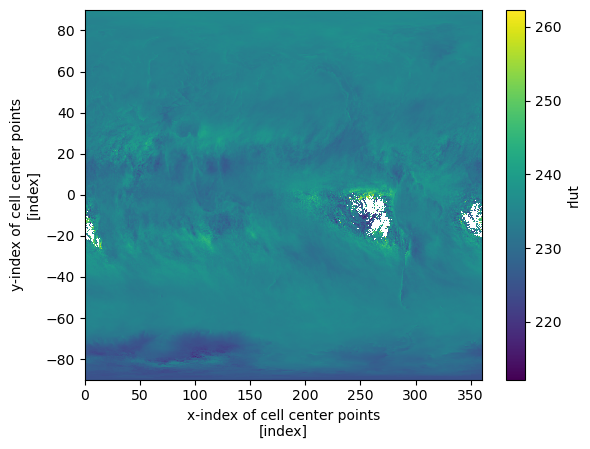

In [13]:
ctt_mean.plot()

In [15]:
# Bin CRE by latitude
lat_bins = np.arange(-90, 91, 10)
lat_binned = temperature.groupby_bins(temperature.grid_yt_coarse, bins=lat_bins)

In [17]:
def prep_lat_data_for_plots(binned, tmin = 200, tmax = 270):
    hist_data = {}
    for bin_name, bin_data in binned:
        with ProgressBar():
            bin_values = bin_data.values.flatten()
            bin_values = bin_values[~np.isnan(bin_values)]
            freq, bin_edges = np.histogram(bin_values, bins=np.arange(tmin, tmax))
            hist_data[bin_name] = (freq, bin_edges)
    return hist_data

In [ ]:
hist_data = prep_lat_data_for_plots(lat_binned)

[########################################] | 100% Completed | 12.27 ss
[########################################] | 100% Completed | 10.86 ss
[########################################] | 100% Completed | 10.99 s
[########################################] | 100% Completed | 11.37 ss
[########################################] | 100% Completed | 11.77 s
[#                                       ] | 3% Completed | 409.38 ms